# Импорты и каталоги

In [3]:
import os
import sqlalchemy
from sqlalchemy import event
import pandas as pd
import psycopg2 as ps
import warnings
warnings.simplefilter("ignore")

In [ ]:
# создание папок для датасетов
try:
    os.mkdir('data_news_csv')
    os.mkdir('data_for_analyze_by_tags')
except:
    print('Already exists')

# Подключение sqlalchemy

In [4]:
# данные для подключения 

username = 'postgres'  # DB username
password = '111'  # DB password
host = 'localhost'  # Public IP address for your instance
port = '5432'  # Port
database = 'postgres'  # Name of database
dbschema = 'news_db'  # Searches left-to-right

In [5]:
# инструмент подключения через sqlalchemy

db_url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(username, password, host, port, database)
engine = sqlalchemy.create_engine(db_url)


# установка search_path для всех транзакций в функционале sqlalchemy

@event.listens_for(engine, "connect", insert=True)
def set_search_path(dbapi_connection, connection_record):
    existing_autocommit = dbapi_connection.autocommit
    dbapi_connection.autocommit = True
    cursor = dbapi_connection.cursor()
    cursor.execute("SET SESSION search_path='%s'" % dbschema)
    cursor.close()
    dbapi_connection.autocommit = existing_autocommit

## Загрузка датасета в базу данных

In [ ]:
# Загрузка датасета в локальную бд по частям

n = 0
length_all = []
for df in pd.read_csv('D:\\netology_diplom\\final\\datasets_files\\lenta-ru-news.csv', chunksize=10000):
    # Обработка каждого DataFrame (chunk)
    # Например, можно сохранить его в базу данных или выводить его статистику
    # print(chunk.info())  # Вывод информации о DataFrame

    # создание столбца id
    df.reset_index(inplace = True)
    df.rename(columns = {'index':'id'}, inplace = True)

    # датасет с заполненными топиками и пустыми тегами
    df_tagsnull = df[df['tags'].isna() & df['topic'].notna()]
    # замена пустых тегов топиками
    df_tagsnull['tags'] = df_tagsnull['topic']
    #print('датасет с заменой пустых тегов топиками:', len(df_tagsnull))

    # датасет с заполненными топиками и тегом "Все"
    df_tagsall = df[(df['tags'] == 'Все') & (df['topic'].notna())]
    #print('датасет с заполненными топиками и тегом "Все":', len(df_tagsall))

    # замена тега "Все" топиками
    df_tagsall['tags'] = df_tagsall['topic']

    # датасет с заполненными топиками и тегами
    df = df[df['tags'].notna() & df['topic'].notna()]
    #print('датасет с заполненными топиками и тегами:', len(df))
    # датасет с топиками и всеми тегами, кроме "Все"
    df = df[(df['tags'] != 'Все') & (df['topic'].notna())]
    #print('датасет с топиками и всеми тегами, кроме "Все":', len(df))

    # объединение датасетов в один обработанный
    df_prepare = pd.concat([df, df_tagsnull, df_tagsall])
    #print('объединение датасетов в один обработанный:', len(df_prepare))
    length_all.append(len(df_prepare))
    #df_prepare.to_csv(f'data_news_csv/news_{n}.csv', index = False)

    #with engine.begin() as connection:
    #    df_prepare.iloc[:].to_sql(f'news_table', index=False, con=connection, if_exists='append', method='multi')

    n += 1
    print(f"\rЗагрузка датасета #{n}: |", '-'*(n)+'>', '|', end="")
    #print()
    #if n == 1:
    #    break

датасет с заменой пустых тегов топиками: 0
датасет с заполненными топиками и тегом "Все": 9995
датасет с заполненными топиками и тегами: 10000
датасет с топиками и всеми тегами, кроме "Все": 5
объединение датасетов в один обработанный: 10000
Загрузка датасета #1: | -> |датасет с заменой пустых тегов топиками: 0
датасет с заполненными топиками и тегом "Все": 10000
датасет с заполненными топиками и тегами: 10000
датасет с топиками и всеми тегами, кроме "Все": 0
объединение датасетов в один обработанный: 10000
Загрузка датасета #2: | --> |датасет с заменой пустых тегов топиками: 0
датасет с заполненными топиками и тегом "Все": 10000
датасет с заполненными топиками и тегами: 10000
датасет с топиками и всеми тегами, кроме "Все": 0
объединение датасетов в один обработанный: 10000
Загрузка датасета #3: | ---> |датасет с заменой пустых тегов топиками: 0
датасет с заполненными топиками и тегом "Все": 10000
датасет с заполненными топиками и тегами: 10000
датасет с топиками и всеми тегами, кроме 

In [ ]:
# количество строк в исходном датасете после обработки
sum(length_all)

738973

# Подключение psycopg2

In [4]:
# инструмент подключения через psycopg2
connection_pg = ps.connect(database=database,user=username, password=password, host=host, port=port)
cursor_pg = connection_pg.cursor()
cursor_pg.execute('set search_path to news_db')
cursor_pg.execute('select tags from news_table group by tags')

data_pg = cursor_pg.fetchall()
try:
    pd.DataFrame(columns = ['id','url','title','text','topic','tags','date'], data = data_pg)
except:
    print(data_pg[:5])

[('69-я параллель',), ('Coцсети',), ('Авто',), ('Автобизнес',), ('Аналитика рынка',)]


# Анализ исходного датасета

In [2]:
def get_tags_count(engine, num=50):
    # получение списка тегов, где количество записей больше 50
    
    if num > 0:
        query = f'''
        select tags, count(id) from news_table nt 
        group by tags
        having count(id) > {int(num)}
        order by count(id) desc
        '''
        df_tags = pd.read_sql_query(query, con = engine)

    else:
        # получение всего списка тегов
        query = '''
        select tags, count(id) from news_table nt 
        group by tags
        order by count(id) desc
        '''
        df_tags = pd.read_sql_query(query, con = engine)
    return df_tags

In [ ]:
df_tags = get_tags_count(engine, num=50)
df_tags

,tags,count
0,Россия,118031
1,Мир,97247
2,Экономика,58357
3,Спорт,43216
4,Культура,34617
...,...,...
85,Социальная сфера,70
86,Первая мировая,65
87,Путешествия,62
88,Вкусы,54


## Сравнение количества новостных публикаций по тегам

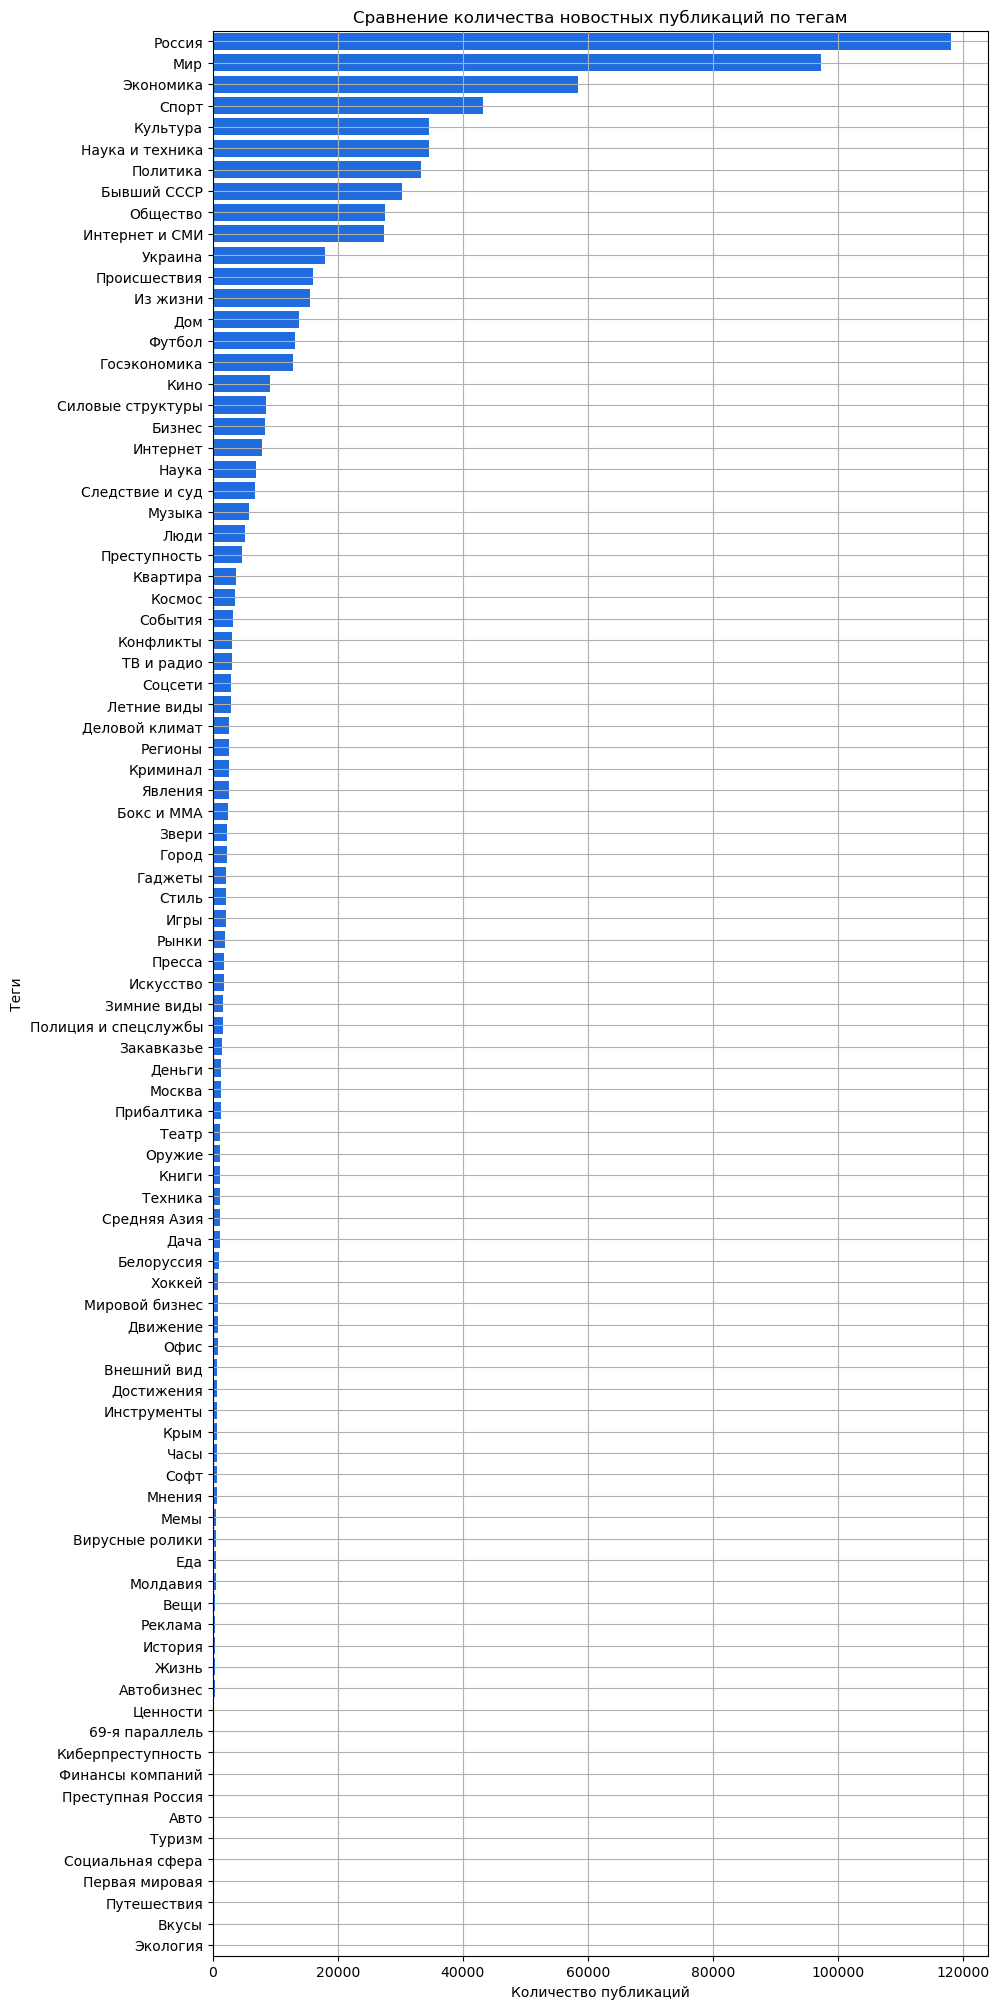

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 25))
sns.barplot(
    x=df_tags['count'],
    y=df_tags['tags'], color="#0066ff")
plt.grid(visible = True)
plt.xlabel('Количество публикаций')
plt.ylabel('Теги')
plt.title('Сравнение количества новостных публикаций по тегам');

## Количество новостей по годам для каждого тега

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go



# инструмент подключения через psycopg
connection_pg = ps.connect(database=database,user=username, password=password, host=host, port=port)
cursor_pg = connection_pg.cursor()
cursor_pg.execute('set search_path to news_db')
# connection_pg.commit()
fig = go.Figure()


# выбор количества строк по каждому тегу с распределением по годам из таблицы с новостями
for tag in df_tags.tags:
    cursor_pg.execute(f'''select year, count(id) from news_table 
    where tags = '{tag}'
    group by year''')
    data_pg_2 = cursor_pg.fetchall()
    df_tags_year = pd.DataFrame(data_pg_2, columns=['year','count'])
    fig.add_traces(
    go.Scatter(
        x=df_tags_year['year'],
        y=df_tags_year['count'],
        mode='lines',
        name=tag)
    )
fig.update_layout(title='Количество новостей по годам для каждого тега')
fig.show()

# Подготовка датасета для дальнейшего исследования

In [ ]:
# проход по полученному списку тегов и выбор первых 1000 строк по каждому тегу при сортировке по id
sum_tags = 0
for tag in df_tags.tags:
    query = f'''
    select * from news_table nt 
    where tags = '{tag}'
    order by id
    limit 1000
    '''
    # сохранение данных по каждому тегу в датафрейм
    df_tag_for_save = pd.read_sql_query(query, con = engine)
    len_df = len(df_tag_for_save)
    sum_tags += len_df
    # сохранение полученного датафрейма по каждому тегу в csv файл с указанием количества строк
    df_tag_for_save.to_csv(f'D:\\netology_diplom\\final\\csv_files\\data_for_analyze_by_tags\\{tag}_{len_df}.csv', index = False)

In [ ]:
# получение списка файлов из папки data_for_analyze_by_tags
csv_list = os.listdir('D:\\netology_diplom\\final\\csv_files\\data_for_analyze_by_tags')
f = 0
for file in csv_list:
    print(f"\r{file[:-4]}:", end="")
    if f == 0:
        df_file = pd.read_csv('D:\\netology_diplom\\final\\csv_files\\data_for_analyze_by_tags\\' + file)
        df_full_data = df_file.drop(df_file.index, inplace = True)
    else:
        df_file = pd.read_csv('D:\\netology_diplom\\final\\csv_files\\data_for_analyze_by_tags\\' + file)
    df_full_data = pd.concat([df_full_data, df_file])
    print(f"\r{file[:-4]}:", 'OK', end="\n")

    f += 1
    #if f==3:
    #    break
df_full_data.to_csv('D:\\netology_diplom\\final\\csv_files\\full_data.csv', index = False)


69-я параллель_181: OK
Coцсети_1000: OK
Авто_141: OK
Автобизнес_310: OK
Белоруссия_916: OK
Бизнес_1000: OK
Бокс и ММА_1000: OK
Бывший СССР_1000: OK
Вещи_424: OK
Вирусные ролики_474: OK
Вкусы_54: OK
Внешний вид_727: OK
Гаджеты_1000: OK
Город_1000: OK
Госэкономика_1000: OK
Дача_1000: OK
Движение_834: OK
Деловой климат_1000: OK
Деньги_1000: OK
Дом_1000: OK
Достижения_718: OK
Еда_457: OK
Жизнь_333: OK
Закавказье_1000: OK
Звери_1000: OK
Зимние виды_1000: OK
Игры_1000: OK
Из жизни_1000: OK
Инструменты_710: OK
Интернет и СМИ_1000: OK
Интернет_1000: OK
Искусство_1000: OK
История_347: OK
Квартира_1000: OK
Киберпреступность_169: OK
Кино_1000: OK
Книги_1000: OK
Конфликты_1000: OK
Космос_1000: OK
Криминал_1000: OK
Крым_666: OK
Культура_1000: OK
Летние виды_1000: OK
Люди_1000: OK
Мемы_477: OK
Мир_1000: OK
Мировой бизнес_854: OK
Мнения_615: OK
Молдавия_439: OK
Москва_1000: OK
Музыка_1000: OK
Наука и техника_1000: OK
Наука_1000: OK
Общество_1000: OK
Оружие_1000: OK
Офис_783: OK
Первая мировая_65: OK


In [51]:
# количество строк в датасете для дальнейшего исследования. Категория "69-параллель" исключена из расчёта
len(df_full_data)

70889

# Лемматизация и обработка текста

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import re

import plotly.graph_objects as go

from selenium import webdriver
from bs4 import BeautifulSoup
from lxml import etree

import ast # Для преобразования строкового представления словаря в словарь

from sklearn.preprocessing import MultiLabelBinarizer

import nltk
from pymystem3 import Mystem
from string import punctuation

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [7]:
df_full_data = pd.read_csv('D:\\netology_diplom\\final\\csv_files\\full_data.csv')
df_full_data['year'] = pd.to_datetime(df_full_data['date']).dt.year
df_fd = df_full_data.drop(columns = ['url','title','topic','date'])
df_fd.drop_duplicates()

,id,text,tags,year
0,450694,"Вице-премьер Владислав Сурков заявил, что не и...",Coцсети,2013
1,450897,"Владислав Цыплухин, занимавший пост руководите...",Coцсети,2013
2,450945,Сервис микроблогов Twitter откроет представите...,Coцсети,2013
3,451084,Ежемесячная аудитория фотосервиса Instagram со...,Coцсети,2013
4,451152,Пользователи Facebook загрузили на Новый год в...,Coцсети,2013
...,...,...,...,...
70884,625679,Американская супермодель Джиджи Хадид разработ...,Явления,2016
70885,625682,Американский предприниматель Марк Фарезе (Mark...,Явления,2016
70886,625720,Новой темой ежегодного Met Gala в музее Метроп...,Явления,2016
70887,625773,Французская актриса Марион Котийяр приняла уча...,Явления,2016


In [ ]:
df_text_tags = df_fd.drop(columns = ['id', 'year'])

df_text_tags_final = pd.get_dummies(df_text_tags, prefix = ['tags'], columns=['tags'])
#print(df_text_tags_final.head())
for i in df_text_tags_final.columns[1:]:
    df_text_tags_final[i] = df_text_tags_final[i].astype(int)

list_col = df_text_tags_final.columns[:1].to_list()
for i in df_text_tags_final.columns[1:].to_list():
    list_col.append(i[5:])
list_col
df_text_tags_final.columns = list_col

df_text_tags_final.to_csv('D:\\netology_diplom\\final\\csv_files\\news_data_lemma.csv', index = False)
df_text_tags_final
#df_text_tags_final=pd.read_csv('D:\\netology_diplom\\final\\csv_files\\news_data_lemma.csv')

,text,Coцсети,Авто,Автобизнес,Белоруссия,Бизнес,Бокс и ММА,Бывший СССР,Вещи,Вирусные ролики,...,Туризм,Украина,Финансы компаний,Футбол,Хоккей,Ценности,Часы,Экология,Экономика,Явления
0,"Вице-премьер Владислав Сурков заявил, что не и...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Владислав Цыплухин, занимавший пост руководите...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Сервис микроблогов Twitter откроет представите...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ежемесячная аудитория фотосервиса Instagram со...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Пользователи Facebook загрузили на Новый год в...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70884,Американская супермодель Джиджи Хадид разработ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
70885,Американский предприниматель Марк Фарезе (Mark...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
70886,Новой темой ежегодного Met Gala в музее Метроп...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
70887,Французская актриса Марион Котийяр приняла уча...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Обработка текста

In [71]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
punctuation = set(punctuation + ' ')
regex = re.compile(r'[А-ЯЁа-яёA-z-]+')
m = Mystem()

def words_only(text, regex=regex):
    '''
    Очистка текста от наборов символов, не являющихся словами,
    и приведение к нижнему регистру
    '''
    try:
        return ' '.join(regex.findall(text)).lower()
    except:
        return ''

def preprocess_text(text):
    '''
    Лемматизация текста и его очистка от стоп-слов
    '''
    text = words_only(text)
    tokens = m.lemmatize(text)
    
    # Удаление токенов, являющихся стоп-словами, либо набором знаков пунктуации
    tokens = [token for token in tokens if token not in stop_words
              and not set(token.strip()) <= punctuation]
    
    text = ' '.join(tokens)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Для ускорения лемматизации произведем объединение текста в группы по 1000 штук,
# используя разделитель ' lllseparatorlll '

size = 1000
sep = ' lllseparatorlll '
df_text_tags_final.insert(loc=1, column='text_lemma', value=[None]*len(df_text_tags_final))

for i in tqdm(range(int(len(df_text_tags_final) / size) + 1)):
    texts = df_text_tags_final[i*size : (i+1)*size]['text']
    texts = preprocess_text(sep.join(texts))
    texts = texts.split(sep)
    df_text_tags_final['text_lemma'][i*size : (i+1)*size] = texts

## Пример лемматизации

In [88]:
for i in [15, 99]:
    get_row = df_text_tags_final.iloc[i]
    print('ИСХОДНЫЙ ТЕКСТ:')
    print(get_row['text'] + '\n')
    print('ЛЕММАТИЗИРОВАННЫЙ ТЕКСТ:')
    print(get_row['text_lemma'] + '\n')
    print('*_'*50 + '*\n')

ИСХОДНЫЙ ТЕКСТ:
Приложение для соцсети Facebook, позволяющее открыто заявлять о своих сексуальных симпатиях, стало хитом. Об этом 1 февраля пишет The Drum. За первую неделю приложение Bang with Friends («Спи с друзьями») скачали более 20 тысяч раз. Для сравнения, согласно статистике центра приложений Facebook, многие приложения ведущих российских СМИ за все время своего существования смогли набрать немногим более десяти тысяч скачиваний. Bang with Friends позволяет пользователям Facebook отмечать среди своих друзей тех, с кем они не отказались бы переспать. Отметки расставляются вручную. Приложение информирует пользователей о счастливых совпадениях — в случае, если отмеченный пользователем друг также отметил его в своем списке. Создатели приложения заявляют, что их целью было помочь людям рассказать правду о своих сексуальных симпатиях. Имена создателей, при этом, не раскрываются. Как отмечает The Drum, популярность Bang with Friends уже привела к появлению приложений-подражателей для 

In [92]:
df_text_tags_final['tags_string'] = df_text_tags_final[list_col[2:]].astype(str).agg(''.join, axis=1)

print('Количество уникальных комбинаций жанров:\t',
      len(df_text_tags_final['tags_string'].unique()))
print('Уникальные комбинации, встречающиеся 1 раз:\t',
      (df_text_tags_final['tags_string'].value_counts() == 1).sum())

df_text_tags_final[['tags_string']].head(2)

Количество уникальных комбинаций жанров:	 89
Уникальные комбинации, встречающиеся 1 раз:	 0


,tags_string
0,1000000000000000000000000000000000000000000000...
1,1000000000000000000000000000000000000000000000...


# Разделение датасета на обучающий и тестовый

In [ ]:
splitter = MultilabelStratifiedShuffleSplit(test_size=0.2, random_state=42)
train_index, test_index = next(splitter.split(X=df_text_tags_final, y=df_text_tags_final[list_col[2:]]))
df_text_tags_final.iloc[train_index][['text_lemma']+list_col[2:]].to_csv('news_train.csv', index=False)
df_text_tags_final.iloc[test_index][['text_lemma']+list_col[2:]].to_csv('news_test.csv', index=False)